# Mechanisitic Interpretability Experiments Notebook

---

### Project Overview

This research focuses on mechanistic interpretability experiments concerning the universality hypothesis -- that different model's trained on the same task will converge to similar internal representations -- as it relates to SOTA segmentation models. We are particularly interested in the hypothesis' applicability in large scale models because so far current research has either focussed on small models as toy experiments or large scale language models. That is, until now there is no work that examines universality in large scale segmentation models.

Therefore, mask2former and unet++ were chosen to test universality. These are both large scale models that provide SOTA performance on many common segmentation tasks and are readily available. The choice of a CNN and transformer based model is intentional. We need contrasting architectures to test universality: we want to see if both a transformer based segmentation model and a CNN based segmentation model will converge to similar internal representations in order to solve the same task. If they do, we will have shown that universality applies.

The task used will be binary segmentation of medical images containing moles and skin legions. The ISIC 2018 dataset will be used due to its relatively small size, availability, and commonality. Both models will be fine-tuned on the same task. We will keep the encoder frozen to take advantage of the extensive pre-training available for both models and make the experiments reproducible. Therefore, mechanistic interepretabiltiy experiments will focus on the fine-tuned decoder as it will be the only component guaranteed to have been trained on the same task, and therefore, the only component that can either demonstrate the presence or absence of universality.

<br>

---

<br>

### Mechanistic Interpretability Notebook

This notebook contains the code and methods used to evaluate the **universality hypothesis** through **mechanistic interpretability** techniques. It focuses on analyzing internal representations of **Unet++** (CNN) and **Mask2Former** (Transformer) using extracted activations from selected **encoder** and **decoder** layers. The notebook compares these representations using metrics such as **SVCCA**, **CKA**, and **RSA**, and visualizes PCA-reduced activation maps to qualitatively inspect similarity. All experimental logic is documented inline, and major methods are defined in local helper functions. To understand where to find specific class or function definitions, hover over the function name. However, all mechanistic interpretability logic is in the python file **experiment.py** This notebook forms the core of our interpretability study to assess whether both models converge to similar internal representations when fine-tuned on the same segmentation task.

All sections will also include markdown formatting before in order to explain the logic, decisions, and results.

<br>

---

### Google Colab Mounting 

This cell is for using google colab. Although, unlike the training notebooks, google colab and CUDA are not necessary for experiments because th edelay for using CPU is not significant. Engineering tricks to reduce memory spikes from operations on flattened transformer activations are employed. Please visit the `experiments.py` file for details and detailed pydocs. If you are on google colab and the data is note yet downloaded. Please execute this cell.


Otherwise, feel free to execute the other cells locally (assuming the data is downloaded locally and in the proper structure).

In [1]:
##############################################
# Google Colab Mounting and Data Downloading #
##############################################

# import ziplefile
import zipfile

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# path to data
data_root = "/content/drive/MyDrive/data.zip"

# unzip data and store in content
with zipfile.ZipFile(data_root, 'r') as zip_ref:
    zip_ref.extractall('/content/data')

Mounted at /content/drive


### Imports

These are the base external dependencies for the entire project.


> ***Note:***    The fix possible truncation using PIL is necessary because unet++ does not have an image processor and pytorch may throw errors if images are truncated,


> ***Note:***    Although segmentation_models_pytorch is only necessary for unet++, certain external .py files require the dependency. You will need to have it installed in order to import these files which contain necessary methods.

> ***Note:***    Although certain imports are not directly accessed, the local modules imported rely on them for functionality. 

In [13]:
###########
# Imports #
###########

# install library for unet++
!pip install segmentation_models_pytorch

import sys
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image, ImageFilter
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gc
import segmentation_models_pytorch as smp
from torch.nn.functional import conv2d
from tqdm import tqdm
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from sklearn.decomposition import PCA
import gdown



# fix possible truncation during training
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True




### Local Imports

These imports are from the python files described above that contain all the necessary code for the research. All files are well documented using py docs so simply hover over method calls and classes for more information or navigation instructions. The files are all named appropriately: it is evident which functionality is contained where.


> ***Note:*** the auto reload is not necessary. It is here because it makes altering the python files while working and running the jupyter notebook much easier. Your changes will be registered immediately This is for those that desire changing the code (working with another model for example or extending the research.)


> ***Note:*** change the path for the project files if your structure is different.

In [15]:

###################
#  Local Imports  #
###################

# auto reload for modules (get rid of old caches that cause errors)
%load_ext autoreload
%autoreload 2

# import correct path for project directory
sys.path.append('/content/drive/MyDrive/mech_interp_segmentation')

# import modules
from dataset import *
from utils import *

####################################################
# All experiment Logic Contained in experiments.py #
####################################################
from experiments import *





### Loading Pretrained Models and Data

This section loads the pretrained models and sets up the dataset for feature extraction and interpretability analysis.

We load both the **Unet++ (CNN)** and **Mask2Former (Transformer)** models from previously saved checkpoints. Each model is loaded along with its corresponding image processor (preprocessing transforms) using the functions `load_model_and_processor_unet` and `load_model_and_processor_mask2former`. These functions abstract away the architecture setup, weight loading, and preprocessing pipeline initialization to make the code cleaner and more modular. The encoder for UNet++ is set to `'resnet34'`, a commonly used encoder that balances performance and efficiency. It is important that the encoder remain the same because `'resnet34'` was used for training. 


<br>

---

<br>

We also define the dataset path and load the training, validation, and test sets using `create_dataloaders`, which returns both the PyTorch DataLoaders and the raw images and masks. These loaders are used later for passing data through the models and for running interpretability experiments.


<br>

---

<br>

> **Note:** The training procedures for both models are fully documented in their respective notebooks:
> - `unetpp.ipynb` (for CNN-based Unet++)  
> - `mask2former.ipynb` (for transformer-based Mask2Former)  
>
> These notebooks contain complete explanations of the training configuration, loss function, metrics, and hyperparameter tuning and reasoning as it relates to the experiments. This current notebook assumes the models have already been trained with the experiments as the goal and focuses exclusively on the **mechanistic interpretability experiments**.



In [16]:
#######################
# Load Trained Models #
#######################


# set seed for reproducibility of experiments
seed = 42
torch.manual_seed(seed)

# set working directory
working_dir = os.getcwd()

# load model CNN

# set encoder name
encoder_name = 'resnet34'

#model_cnn, image_processor_unet=load_model_and_processor_unet(save_dir=(working_dir + '/drive/MyDrive/mech_interp_segmentation/models/unet/unetpp_epoch10_batch16'), encoder_name=encoder_name, num_labels=1)
model_cnn, image_processor_unet=load_model_and_processor_unet(save_dir=(working_dir + '/models/unet/unetpp_epoch10_batch16'), encoder_name=encoder_name, num_labels=1)

# load model Transformer
#model_transformer, image_processor_transformer = load_model_and_processor_mask2former(working_dir + '/drive/MyDrive/mech_interp_segmentation/models/transformer/mask2former_epoch10_batch16')
model_transformer, image_processor_transformer = load_model_and_processor_mask2former(working_dir + '/models/transformer/mask2former_epoch10_batch16')



# load data
data_root = working_dir + '/data/data/'

# define the loaders
train_loader, val_loader, test_loader, train_images, val_images, test_images, train_masks, val_masks, test_masks = create_dataloaders(data_root, batch_size=16)


/Users/brandonleblanc/COMP_432_MECH_INTERP/mech_interp_segmentation/utils.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join

model loaded from /Users/brandonleblanc/COMP_432_MECH_INTERP/mech_interp_segmentation/models/unet/unetpp_epoch10_batch16
Model and image processor loaded from /Users/brandonleblanc/COMP_432_MECH_INTERP/mech_interp_segmentation/models/transformer/mask2former_epoch10_batch16



### Inspecting Model Layers

Before running interpretability experiments, we first inspect the architecture of each model to find the most appropirate modules, activations, and layers to experiment on. This is important because we must find matching layers between both models. That is, the layers compared must have corresponding representational meaning. For example, we can compare lower level encoder modules against each other. If we compare segmentation heads, we must find both corresponding modules in the different models which will be in different locations with different names.

<br>

---

<br>

We use two separate helper functions for this:

- `print_trainable_layers_unet(model_cnn)` for **UNet++**
- `print_trainable_layers_mask2former(model_transformer)` for **Mask2Former**

Each function prints all named layers in the model along with their trainable status (i.e., whether `requires_grad` is `True`). This allows us to verify that the encoders remain frozen while the decoders are being fine-tuned — essential for training but not important here. Here we use the methods to inspect the models for the layers that will be most important for the experiments -- **Feature extraction** decisions for encoder vs. decoder and the modules that should be used.


In [17]:
# print the layers of the model to make decisions on which layers to freeze
print("Layers of the UNet++ Model")
print_trainable_layers_unet(model_cnn)

print("\n\n\n Layers of the Mask2Former Model")
print_trainable_layers_mask2former(model_transformer)



Layers of the UNet++ Model
encoder.conv1.weight is trainable
encoder.bn1.weight is trainable
encoder.bn1.bias is trainable
encoder.layer1.0.conv1.weight is trainable
encoder.layer1.0.bn1.weight is trainable
encoder.layer1.0.bn1.bias is trainable
encoder.layer1.0.conv2.weight is trainable
encoder.layer1.0.bn2.weight is trainable
encoder.layer1.0.bn2.bias is trainable
encoder.layer1.1.conv1.weight is trainable
encoder.layer1.1.bn1.weight is trainable
encoder.layer1.1.bn1.bias is trainable
encoder.layer1.1.conv2.weight is trainable
encoder.layer1.1.bn2.weight is trainable
encoder.layer1.1.bn2.bias is trainable
encoder.layer1.2.conv1.weight is trainable
encoder.layer1.2.bn1.weight is trainable
encoder.layer1.2.bn1.bias is trainable
encoder.layer1.2.conv2.weight is trainable
encoder.layer1.2.bn2.weight is trainable
encoder.layer1.2.bn2.bias is trainable
encoder.layer2.0.conv1.weight is trainable
encoder.layer2.0.bn1.weight is trainable
encoder.layer2.0.bn1.bias is trainable
encoder.layer2.0



### Selecting and Investigating Candidate Layers

To evaluate the **universality hypothesis**, we must identify and extract intermediate representations from corresponding layers across both **UNet++** (CNN) and **Mask2Former** (Transformer). This section defines the candidate layers for both models and prints their activation shapes for verification.

<br>

---

<br>

#### Candidate Layer Selection

- For **UNet++**, we select:
  - Two **encoder** layers: `layer3` (mid-level) and `layer4` (high-level)
  - Two **decoder** layers: an intermediate decoder block and the final segmentation head

- For **Mask2Former**, we select:
  - Two **encoder** layers: normalized patch embeddings and a deep transformer block output
  - One **decoder** layer: the mask embedder used in the final segmentation head

These layers are chosen to capture both:
- **Encoder features**, which are **frozen during fine-tuning**
- **Decoder features**, which are **task-specific and fine-tuned** on the ISIC 2018 dataset

> While investigating the frozen encoder layers may seem counterintuitive, this serves two important purposes:
> 1. It allows us to test whether the two models — pretrained independently on large-scale datasets — converge to **similar internal representations** even before fine-tuning. This provides insight into **representational universality during pretraining**.
> 2. It provides a **contrast to the decoder layers**, which were actively fine-tuned on the same binary segmentation task, and therefore are the expected site for universal convergence if it exists.

<br>

---

<br>


#### Shape Investigation

We pass a single batch of validation data through both models using the `investigate_candidate_layers` function. This uses forward hooks to collect activations from each selected layer and prints the resulting tensor shapes. This step confirms:
- Hooks are correctly attached to each target layer
- Activation tensors have expected dimensionality
- Layer choices are appropriate for downstream similarity comparisons (e.g., SVCCA, CKA)

This ensures the interpretability pipeline is properly set up before running metric-based comparisons across models.
```

In [18]:
# candidate layer lists for unet++ (CNN)
unet_encoder_candidates = [
    "encoder.layer3",  # mid-level encoder features
    "encoder.layer4"   # high-level encoder features
]
unet_decoder_candidates = [
    "decoder.blocks.x_1_1.conv1",  # a decoder block (fine-tuned features)
    "segmentation_head.0"          # final segmentation head output
]

# candidate layer lists for Mask2Former (Transformer)
mask2former_encoder_candidates = [
    "model.pixel_level_module.encoder.embeddings.norm",  # normalized patch embeddings
    "model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense"  # intermediate high-level features
]
mask2former_decoder_candidates = [
    "model.transformer_module.decoder.mask_predictor.mask_embedder.0.0"  # decoder mask embedder (task-specific)
]

# combine candidate layers for each model
unet_candidates = unet_encoder_candidates + unet_decoder_candidates
mask2former_candidates = mask2former_encoder_candidates + mask2former_decoder_candidates



#  investigation for both models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# move to device
model_cnn.to(device)
model_transformer.to(device)

# investigate the candidate layers
# this function will investigate activation shapes to ensure
#that metric experiments are possible
# function takes advantage of multiple other functions in experiments.py
# navigate to experiments.py to see the implementation
print("Investigating UNet++ candidate layers:")
investigate_candidate_layers(model_cnn, unet_encoder_candidates + unet_decoder_candidates, val_loader, device)

print("\nInvestigating Mask2Former candidate layers:")
investigate_candidate_layers(model_transformer, mask2former_encoder_candidates + mask2former_decoder_candidates, val_loader, device)


Investigating UNet++ candidate layers:


Extracting features for candidate layers:   0%|          | 0/7 [00:38<?, ?it/s]


Candidate Layers and their Activation Shapes:


Investigating candidate layers: 100%|██████████| 00:00


Layer 'encoder.layer3': shape torch.Size([16, 256, 8, 8])
Layer 'encoder.layer4': shape torch.Size([16, 512, 4, 4])
Layer 'decoder.blocks.x_1_1.conv1': shape torch.Size([16, 128, 16, 16])
Layer 'segmentation_head.0': shape torch.Size([16, 1, 128, 128])

Investigating Mask2Former candidate layers:


Extracting features for candidate layers:   0%|          | 0/7 [00:38<?, ?it/s]


Candidate Layers and their Activation Shapes:


Investigating candidate layers: 100%|██████████| 00:00

Layer 'model.pixel_level_module.encoder.embeddings.norm': shape torch.Size([16, 1024, 128])
Layer 'model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense': shape torch.Size([16, 64, 512])
Layer 'model.transformer_module.decoder.mask_predictor.mask_embedder.0.0': shape torch.Size([160, 100, 256])




### Extracting Features and Comparing Representations

Once candidate layers are selected, we extract activations from both models and compare their internal representations using similarity metrics. This is the core step in testing the **universality hypothesis**.

<br>

---

<br>

#### Feature Extraction

We use the `extract_features` function (defined in `experiments.py`) to register forward hooks and extract activations from:
- All candidate **encoder** and **decoder** layers for **UNet++**
- All candidate **encoder** and **decoder** layers for **Mask2Former**

The activations are stored in dictionaries (`features_unet` and `features_mask2former`) mapping layer names to tensors of shape `[batch_size, channels, height, width]` or `[batch_size, hidden_dim, seq_len]`, depending on the model.


<br>

---

<br>

#### Encoder and Decoder Comparison

Two helper functions are defined:
- `run_encoder_comparison(idx)` compares encoder layers across both models, using corresponding layers at index `idx` in each list.
- `run_decoder_comparison(idx)` compares each decoder layer in UNet++ to the primary decoder layer in Mask2Former (`mask_embedder.0.0`), reflecting their task-specific representations.

Each comparison uses the `print_layer_comparison` function, which computes:
- **Linear CKA**: a measure of alignment between representations using centered kernel dot products.
- **SVCCA (Truncated)**: a similarity score based on the top `k=20` singular vectors of the flattened activations.

Garbage collection and CUDA memory flushing are performed after each comparison to prevent memory spikes — especially important when working with large models and high-resolution feature maps.

> This section directly probes whether the **internal representations** learned by a CNN and a transformer converge to **similar geometric structures** across their respective layers when solving the same segmentation task.

> the DEBUG statements are kept active to inspect shapes for further processing and visualizations using PCA (see below)


In [20]:
# set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define your candidate layer lists for UNet++ and Mask2Former
unet_encoder_candidates = [
    "encoder.layer3",  # mid-level encoder features
    "encoder.layer4"   # high-level encoder features
]
unet_decoder_candidates = [
    "decoder.blocks.x_1_1.conv1",  # decoder block features
    "segmentation_head.0"          # final segmentation head output
]
mask2former_encoder_candidates = [
    "model.pixel_level_module.encoder.embeddings.norm",  # normalized patch embeddings
    "model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense"  # high-level encoder output
]
mask2former_decoder_candidates = [
    "model.transformer_module.decoder.mask_predictor.mask_embedder.0.0"  # decoder mask embedder
]

# model_cnn, model_transformer, val_loader

# extract features from candidate layers for both models.
print("Extracting features from UNet++ candidate layers...")
features_unet = extract_features(model_cnn, val_loader, unet_encoder_candidates + unet_decoder_candidates, device=device)
print("Extracting features from Mask2Former candidate layers...")
features_mask2former = extract_features(model_transformer, val_loader, mask2former_encoder_candidates + mask2former_decoder_candidates, device=device)



def run_encoder_comparison(idx):
    # 2rap the encoder comparison in a local function scope
    layer_unet = unet_encoder_candidates[idx]
    layer_mask2former = mask2former_encoder_candidates[idx]

    # Call the print function which internally calls compare_layer_pair
    print_layer_comparison(features_unet, features_mask2former,
                           layer_unet, layer_mask2former,
                           n_samples=500, k_svcca=20)



# loop over encoder candidate layers in a function scope
for i in range(len(unet_encoder_candidates)):
    run_encoder_comparison(i)

    # force garbage collection and empty CUDA cache after each iteration
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def run_decoder_comparison(idx):
    # wrap the decoder comparison in a local function scope
    layer_unet = unet_decoder_candidates[idx]
    # using the single decoder candidate from Mask2Former
    layer_mask2former = mask2former_decoder_candidates[0]

    print_layer_comparison(features_unet, features_mask2former,
                           layer_unet, layer_mask2former,
                           n_samples=500, k_svcca=20)

# loop over decoder candidate layers in a function scope
for i in range(len(unet_decoder_candidates)):
    run_decoder_comparison(i)

    # force garbage collection and empty CUDA cache after each iteration
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

Extracting features from UNet++ candidate layers...


Extracting Features: 100%|██████████| 7/7 [00:46<00:00,  6.57s/it]


Extracting features from Mask2Former candidate layers...


Extracting Features: 100%|██████████| 7/7 [00:46<00:00,  6.71s/it]


[DEBUG] encoder.layer3 shape after subsampling: torch.Size([100, 256, 1, 1])
[DEBUG] model.pixel_level_module.encoder.embeddings.norm shape after subsampling: torch.Size([100, 1024, 1])
[DEBUG] encoder.layer3 flattened shape: torch.Size([100, 256])
[DEBUG] model.pixel_level_module.encoder.embeddings.norm flattened shape: torch.Size([100, 1024])
Comparing UNet++ 'encoder.layer3' vs Mask2Former 'model.pixel_level_module.encoder.embeddings.norm':
  Linear CKA: 0.3569
  SVCCA: -0.0475

[DEBUG] encoder.layer4 shape after subsampling: torch.Size([100, 512, 1, 1])
[DEBUG] model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense shape after subsampling: torch.Size([100, 64, 1])
[DEBUG] encoder.layer4 flattened shape: torch.Size([100, 512])
[DEBUG] model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense flattened shape: torch.Size([100, 64])
Comparing UNet++ 'encoder.layer4' vs Mask2Former 'model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense':


### Results: Representation Similarity Across Architectures

This section presents the results of comparing internal representations between UNet++ and Mask2Former across selected encoder and decoder layers. Each pair of layers was evaluated using Linear CKA and truncated SVCCA (done to avoid large memory spikes up to 50GB due to the large size the flattened mask2former norm module output). Activations were adaptively pooled, flattened, and subsampled (to 100 samples) to further ensure memory efficiency and comparability. 

---

#### Encoder Layer Comparisons (Frozen)

Although these encoder layers were frozen during fine-tuning, they had been pretrained on large datasets. Examining them reveals whether pretraining alone can lead to representational alignment across very different architectures.

| UNet++ Layer         | Mask2Former Layer                                                           | Linear CKA | SVCCA    |
|----------------------|-----------------------------------------------------------------------------|------------|----------|
| `encoder.layer3`     | `model.pixel_level_module.encoder.embeddings.norm`                         | **0.3569** | -0.0475  |
| `encoder.layer4`     | `model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense`  | **0.2382** | -0.0353  |

- **Layer3 Comparison:**  
  The comparison of UNet++'s `encoder.layer3` versus Mask2Former's `model.pixel_level_module.encoder.embeddings.norm` shows a moderate linear similarity (Linear CKA ≈ 0.3569), indicating some alignment in mid-level features. However, the slightly negative SVCCA (-0.0475) suggests that the subspace alignment between these heterogeneous activations is weak or unstable.

- **Layer4 Comparison:**  
  The UNet++ `encoder.layer4` compared to Mask2Former's `model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense` gives a lower linear similarity (Linear CKA ≈ 0.2382) with a similarly negative SVCCA (-0.0353), implying that higher-level encoder features are even less aligned between the models.

---

#### Decoder Layer Comparisons (Fine-tuned)

Decoder layers, which are fine-tuned for the segmentation task, are particularly important for assessing representation convergence. The following comparisons were made:

| UNet++ Layer                  | Mask2Former Layer                                                  | Linear CKA | SVCCA   |
|-------------------------------|---------------------------------------------------------------------|------------|---------|
| `decoder.blocks.x_1_1.conv1`  | `model.transformer_module.decoder.mask_predictor.mask_embedder.0.0` | **0.0682** | 0.0196  |
| `segmentation_head.0`         | `model.transformer_module.decoder.mask_predictor.mask_embedder.0.0` | **0.0367** | nan     |

- **Decoder Block Comparison:**  
  Comparing UNet++'s `decoder.blocks.x_1_1.conv1` with Mask2Former's `mask_embedder.0.0` shows a Linear CKA of approximately 0.0682 and a small but positive SVCCA (0.0196), indicating that the fine-tuned decoder representations have minimal alignment between the architectures.

- **Final Output Comparison:**  
  The final output comparison between UNet++'s `segmentation_head.0` and Mask2Former's corresponding branch shows a very low Linear CKA (≈ 0.0367) and an undefined SVCCA (nan), likely due to the extremely low dimensionality (only 1 channel) of UNet++'s final output.

---

#### Summary of Findings

- **Encoder Representations:**  
  There is moderate linear similarity in the encoder layers (Linear CKA ≈ 0.3569 for `encoder.layer3`), suggesting that pretraining provides some common feature structure. However, the negative SVCCA values indicate that subspace alignment is inconsistent, reflecting the challenges in comparing representations across architectures.

- **Decoder Representations:**  
  Fine-tuned decoder layers show very low alignment using both linear (Linear CKA ≈ 0.0682 and 0.0367) and subspace (SVCCA ≈ 0.0196 and nan) metrics, emphasizing that the task-specific representations remain fundamentally distinct.

- **Overall Implications:**  
  The quantitative analysis indicates that although there is some latent similarity in the encoder layers, the decoder representations are heavily influenced by architectural design. This suggests that even when models are trained on the same segmentation task, their internal representations do not fully converge. Additional projection techniques (e.g., canonical correlation analysis, Procrustes analysis, or manifold alignment) may be required to better align and compare these latent spaces.

---

Overall, the results support the conclusion that while pretraining induces some commonality in early-stage representations, the specialized decoders of UNet++ and Mask2Former remain largely divergent due to their inherent architectural differences.


<br>
<br>
<br>

---

### Expanded Decoder Comparisons: Multi-Branch Evaluation with Nonlinear Metrics

This section deepens the analysis of decoder similarity by comparing each **UNet++ decoder layer** against all three **Mask2Former decoder branches**. These comparisons help evaluate whether different architectural pathways ultimately converge to similar internal representations when fine-tuned on the same task.

---

### Decoder Candidate Layers

define the following decoder layers:

- **UNet++**  
  - `decoder.blocks.x_1_1.conv1`: Intermediate decoder block  
  - `segmentation_head.0`: Final segmentation head output

- **Mask2Former**  
  - `mask_embedder.0.0`: Primary output head  
  - `mask_embedder.1.0`: Alternative decoder branch  
  - `mask_embedder.2.0`: Additional alternative branch

The mask embedder layers represent different branches in the final Transformer decoder. Comparing them to UNet++ allows us to assess whether **semantic convergence** occurs in the learned representations — especially near the task output.

---

### Motivation for Extended Analysis

In the **initial decoder comparisons** (see earlier results), we observed the following:

- **Linear CKA scores were near zero**
- **SVCCA scores were extremely low or undefined**

This raised a critical question:

> Are the representations genuinely dissimilar — or simply nonlinearly related in a way that linear metrics do not capture?

To investigate further, incorporate **non-linear similarity metrics** that can capture representational alignment **beyond direct geometry**.

---

### Using Non-linear metrics

1. **Kernel CKA**  
   A nonlinear extension of CKA using an **RBF kernel**, which evaluates similarity in the **manifold structure** of feature spaces.  
   This is particularly important when comparing a CNN with local receptive fields (UNet++) to a Transformer using global attention (Mask2Former), where their representations may encode similar information but lie on **nonlinearly aligned subspaces**.

2. **RSA (Representational Similarity Analysis)**  
   Compares **pairwise dissimilarities** between examples, rather than raw features.  
   This provides a task-centric measure of alignment:  
   - Do the models distinguish between examples in similar ways?  
   - Even if the internal feature geometry differs?

These metrics are implemented in `experiments.py` as `compute_kernel_cka()` and `compare_rdm_similarity()`.

---

### Procedure

1. **Feature Extraction**  
   Use forward hooks to collect activations from each decoder layer over the validation set, then apply:
   - Adaptive average pooling (to reduce dimensionality)
   - Subsampling (to limit memory usage)
   - Flattening (for metric computation)

2. **Cross-Layer Comparison**  
   For each pair of layers, we compute:
   - **Linear CKA**
   - **SVCCA**
   - **Kernel CKA**
   - **RSA Spearman Correlation**

3. **Execution**  
   All combinations of UNet++ decoder layers × Mask2Former decoder branches are compared using the `run_decoder_comparisons()` function.

---

> This expanded decoder analysis provides a more robust, architecture-agnostic approach to whether universal representations emerge not just geometrically, but functionally and relationally. Thereby, confirming the above results if the same patterns and analyses are observed.

```

In [21]:

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# define your candidate layer lists for UNet++ and Mask2Former
unet_encoder_candidates = [
    "encoder.layer3",  # mid-level encoder features
    "encoder.layer4"   # high-level encoder features
]

mask2former_encoder_candidates = [
    "model.pixel_level_module.encoder.embeddings.norm",  # normalized patch embeddings
    "model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense"  # high-level encoder output
]
# define Candidate Layers (Decoder Focus)
unet_decoder_candidates = [
    "decoder.blocks.x_1_1.conv1",  # intermediate decoder block features
    "segmentation_head.0"          # final segmentation head output
]

mask2former_decoder_candidates = [
    "model.transformer_module.decoder.mask_predictor.mask_embedder.0.0",  # primary mask embedder output
    "model.transformer_module.decoder.mask_predictor.mask_embedder.1.0",  # alternative branch
    "model.transformer_module.decoder.mask_predictor.mask_embedder.2.0"   # alternative branch
    
]

# feature Extraction
print("Extracting features from UNet++ decoder candidate layers...")
features_unet_decoder = extract_features(model_cnn, val_loader, unet_decoder_candidates, device=device)
print("Extracting features from Mask2Former decoder candidate layers...")
features_mask2former_decoder = extract_features(model_transformer, val_loader, mask2former_decoder_candidates, device=device)

# define a Function to Compare Final Representations
def compare_final_representations(unet_layer, mask2former_layer, n_samples=500, k_svcca=20):
    
    print_layer_comparison(features_unet_decoder, features_mask2former_decoder,
                           unet_layer, mask2former_layer,
                           n_samples=n_samples, k_svcca=k_svcca)
    #  compute and print alternative metrics:
    acts_unet = features_unet_decoder[unet_layer]
    acts_mask2former = features_mask2former_decoder[mask2former_layer]

    # pool activations
    acts_unet = F.adaptive_avg_pool2d(acts_unet, (1,1)) if acts_unet.dim() == 4 else F.adaptive_avg_pool1d(acts_unet, 1)
    acts_mask2former = F.adaptive_avg_pool2d(acts_mask2former, (1,1)) if acts_mask2former.dim() == 4 else F.adaptive_avg_pool1d(acts_mask2former, 1)

    # subsample and equalize sample size
    acts_unet = subsample_tensor(acts_unet, n_samples=n_samples)
    acts_mask2former = subsample_tensor(acts_mask2former, n_samples=n_samples)
    n_common = min(acts_unet.size(0), acts_mask2former.size(0))
    acts_unet = subsample_tensor(acts_unet, n_samples=n_common)
    acts_mask2former = subsample_tensor(acts_mask2former, n_samples=n_common)

    X = acts_unet.view(acts_unet.size(0), -1).cpu().numpy()
    Y = acts_mask2former.view(acts_mask2former.size(0), -1).cpu().numpy()

    # compute Kernel CKA
    kernel_cka_score = compute_kernel_cka(X, Y)
    print(f"Kernel CKA: {kernel_cka_score:.4f}")

    # compute RSA-based similarity (Spearman correlation of RDMs)
    rsa_similarity = compare_rdm_similarity(X, Y, metric='correlation')
    print(f"RSA Spearman Correlation: {rsa_similarity:.4f}\n")

# run comparisons helper method
def run_comparisons():
    # loop over every combination of UNet++ and Mask2Former decoder candidates.
    for unet_layer in unet_decoder_candidates:
        for mask2former_layer in mask2former_decoder_candidates:
            print(f"Comparing UNet++ '{unet_layer}' vs Mask2Former '{mask2former_layer}':")
            compare_final_representations(unet_layer, mask2former_layer, n_samples=500, k_svcca=20)
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

# execute the comparisons
run_comparisons()

Extracting features from UNet++ decoder candidate layers...


Extracting Features: 100%|██████████| 7/7 [00:45<00:00,  6.51s/it]


Extracting features from Mask2Former decoder candidate layers...


Extracting Features: 100%|██████████| 7/7 [00:45<00:00,  6.45s/it]


Comparing UNet++ 'decoder.blocks.x_1_1.conv1' vs Mask2Former 'model.transformer_module.decoder.mask_predictor.mask_embedder.0.0':
[DEBUG] decoder.blocks.x_1_1.conv1 shape after subsampling: torch.Size([100, 128, 1, 1])
[DEBUG] model.transformer_module.decoder.mask_predictor.mask_embedder.0.0 shape after subsampling: torch.Size([500, 100, 1])
[DEBUG] decoder.blocks.x_1_1.conv1 flattened shape: torch.Size([100, 128])
[DEBUG] model.transformer_module.decoder.mask_predictor.mask_embedder.0.0 flattened shape: torch.Size([100, 100])
Comparing UNet++ 'decoder.blocks.x_1_1.conv1' vs Mask2Former 'model.transformer_module.decoder.mask_predictor.mask_embedder.0.0':
  Linear CKA: 0.0295
  SVCCA: 0.0208

Kernel CKA: 0.0818
RSA Spearman Correlation: 0.0094

Comparing UNet++ 'decoder.blocks.x_1_1.conv1' vs Mask2Former 'model.transformer_module.decoder.mask_predictor.mask_embedder.1.0':
[DEBUG] decoder.blocks.x_1_1.conv1 shape after subsampling: torch.Size([100, 128, 1, 1])
[DEBUG] model.transformer_m

### Decoder Similarity Results: UNet++ vs Mask2Former

This section presents a comparison of decoder layer representations between Unet++ and Mask2Former using a variety of similarity metrics. The analysis employs both linear metrics (CKA, SVCCA) and nonlinear metrics (Kernel CKA, RSA) to investigate whether the representations in Transformer-based decoders align with those in CNN-based decoders when fine-tuned on the same segmentation task.

All activations were adaptively pooled to avoid memory spikes, subsampled to 100 examples, and flattened before comparison. Kernel CKA was normalized to fall in [0, 1] using an HSIC-based formulation (see `experiments.py`).

---

#### Decoder Layer Comparison Summary

| UNet++ Layer            | Mask2Former Layer                                              | Linear CKA | SVCCA    | Kernel CKA | RSA (Spearman) |
|-------------------------|----------------------------------------------------------------|------------|----------|-------------|----------------|
| `conv1`                 | `mask_embedder.0.0`                                            | 0.0295     | 0.0208   | **0.0818**  | 0.0094         |
| `conv1`                 | `mask_embedder.1.0`                                            | 0.0246     | -0.0435  | **0.0768**  | -0.0273        |
| `conv1`                 | `mask_embedder.2.0`                                            | 0.0516     | 0.0209   | **0.0602**  | 0.0121         |
| `segmentation_head.0`  | `mask_embedder.0.0`                                            | 0.0639     | nan      | **0.0349**  | nan            |
| `segmentation_head.0`  | `mask_embedder.1.0`                                            | 0.0010     | nan      | **0.0254**  | nan            |
| `segmentation_head.0`  | `mask_embedder.2.0`                                            | 0.0204     | nan      | **0.0114**  | nan            |

---

#### Key Observations

- **Linear Metrics are Low:**  
  Linear CKA values for all decoder comparisons are very low (ranging from approximately 0.0010 to 0.0639), indicating minimal direct linear alignment between UNet++ and Mask2Former decoder representations (same as above -- confirming what we have previously seen).

- **SVCCA Consistency Issues:**  
  SVCCA values are either very low or negative (e.g., -0.0435) and are undefined (nan) for comparisons involving `segmentation_head.0`. This is likely due to the extremely low dimensionality of UNet++’s final output, resulting in a collapsed feature space. 

- **Nonlinear Metrics Reveal Modest Alignment:**  
  Kernel CKA values show slightly higher similarity in certain cases, with the highest observed value of 0.0818 for the `conv1` pair with `mask_embedder.0.0`. However, these values remain relatively low overall, implying that any latent nonlinear alignment is weak.  
  RSA (Spearman Correlation) also returns values near zero or slightly negative, further underscoring the limited alignment in the relative activation structures.

- **Decoder Divergence:**  
  The final output of UNet++ (`segmentation_head.0`) demonstrates negligible alignment with Mask2Former decoder branches, as shown by Linear CKA values ranging from 0.0010 to 0.0639 and undefined or very low SVCCA and RSA scores. This emphasizes that the fine-tuned decoders maintain architecture-specific representations despite both models being trained on the same segmentation task and having the same performance.

---

#### Interpretation & Takeaways

Decoder representations from UNet++ and Mask2Former do not align well in a linear sense, consistent with the fundamental architectural divergence between convolutional and transformer-based approaches. Although modest nonlinear similarities are captured by Kernel CKA, these values remain low, indicating that the overall latent manifolds of the decoder outputs are largely distinct.

The results suggest that even when both models are carefully fine-tuned on the same segmentation task with similar performance, the impact of architectural design is dominant—resulting in distinct decoder representations. The low alignment metrics, particularly in the final output layers, underscore that additional advanced projection techniques (such as canonical correlation analysis, Procrustes analysis, or manifold alignment) may be required to project these features into a common latent space for more meaningful comparison. This could be a direction of future research. 

Overall, the quantitative metrics indicate that while some latent similarity might exist in intermediate decoder layers (e.g., the `conv1` layer), the representations remain fundamentally influenced by architectural design.


---

<br>
<br>

### Visualization of Internal Representations

In this section, we directly inspect the internal activations of our segmentation models—UNet++ and Mask2Former—by visualizing key layer outputs. The goal is to see if and how these models trained on the same task produce similar internal representations. Although, given the above results, we are looking to confirm or cast doubt on them by showing the absence or presence of any visual alignment.

Our findings show:
- **Encoder Layers**: These pretrained layers show moderate alignment, suggesting some convergence in mid-level features across architectures.
- **Decoder Layers**: Although linear metrics for the decoders are very low, nonlinear measures (like Kernel CKA) indicate that some small latent, nonlinear similarities exist. However, it is important to note that the non-linear metrics are so modest that they also cast down on universality rather than confirm it.

Focus the visualization on:
1. **Encoder Layers**: To check the effect of pretraining on feature representations.
2. **Decoder Layers with High Nonlinear Similarity**: Specifically, we visualize UNet++’s `decoder.blocks.x_1_1.conv1` against Mask2Former’s `mask_embedder.0.0`, as this pair had the best Kernel CKA score.

To make these activations visually comparable:
- Apply PCA to reduce the high-dimensional activations to three principal components, effectively creating “RGB” images.
- Note that Transformer activations may naturally appear as line graphs (or flat vectors) due to their architecture, which makes direct spatial comparisons difficult. PCA helps to reshape these activations into a format that can be visually compared.

> **Note:** This section is intentionally self-contained. All functions and underlying logic for the visualization are provided within the notebook (instead of being placed in an external file like `experiments.py`) so you can examine and modify the code directly. This was done because it is rather abstract, involving a lot of dimension matching, and makes the process easier to understand.


---

<br>
<br>

### Visualization Functions

In this section, two key functions are  defined to help us inspect and compare the activation maps from our segmentation models—Unet++ and Mask2Former. These functions allow us to see the spatial (or sequential) patterns in the activations for selected samples and channels.

#### 1. `visualize_activation_maps`

- **Purpose:**  
  Visualizes activation maps for selected samples and channels.
  
- **Functionality:**  
  - Accepts an activation tensor that can be in one of several formats:
    - `[N, C, H, W]` for typical CNN-like outputs.
    - `[N, C, L]` for outputs that might be more sequence-like (as in some Transformer layers).
  - Ensures the tensor has four dimensions by adding single dimensions if necessary.
  - Iterates over specified sample indices and channels:
    - If the activation is 1D (, it plots it as a line graph.
    - If the activation is 2D, it uses `imshow` to display it as an image.
    - For activations with more than 2 dimensions, it defaults to showing the first slice.
  - Labels each subplot with a title containing a provided prefix, sample index, and channel number.

#### 2. `compare_activation_maps`

- **Purpose:**  
  Compares activation maps from two different models (UNet++ and Mask2Former) side by side.
  
- **Functionality:**  
  - Accepts two dictionaries of activation maps (one for each model), where each key corresponds to a layer name.
  - Retrieves the activation tensors for the specified layers.
  - Calls `visualize_activation_maps` on each tensor to display the activation maps for the same sample indices and channels.
  - This side-by-side comparison allows us to qualitatively assess the similarity (or difference) in the spatial patterns of the activations between the two models.

<br>
<br>

> **Note:** Since activation visualization can be abstract and complicated, all the functions and underlying logic are included directly within the notebook (rather than in an external file). This makes it easier for you to examine, modify, and understand the visualization process.

In [22]:

def visualize_activation_maps(activations, sample_indices=[0], channels_to_show=[0, 1, 2], title_prefix=""):
    """
    Visualize activation maps for selected samples and channels.

    Parameters:
        activations (torch.Tensor): Activation tensor of shape [N, C, H, W] or [N, C, L].
        sample_indices (list of int): Indices of samples to visualize.
        channels_to_show (list of int): Channels to visualize for each sample.
        title_prefix (str): Prefix for subplot titles.
    """
    # Ensure activations are on CPU and detached
    activations = activations.detach().cpu()

    # if activations are [N, C, L], unsqueeze to get [N, C, L, 1] for consistency
    if activations.dim() == 3:
        activations = activations.unsqueeze(-1)
    # if activations are [N, C], unsqueeze to get [N, C, 1, 1] for consistency
    if activations.dim() == 2:
        activations = activations.unsqueeze(-1).unsqueeze(-1)

    num_samples = len(sample_indices)
    num_channels = len(channels_to_show)

    fig, axes = plt.subplots(num_samples, num_channels, figsize=(3 * num_channels, 3 * num_samples))

    # make sure axes is always a 2D list
    if num_samples == 1:
        axes = [axes]  # make it a list of one row
    if num_channels == 1:
        axes = [[ax] for ax in axes]

    for i, sample_idx in enumerate(sample_indices):
        for j, channel_idx in enumerate(channels_to_show):
            # check bounds
            if sample_idx >= activations.shape[0] or channel_idx >= activations.shape[1]:
                axes[i][j].axis('off')
                continue
            act = activations[sample_idx, channel_idx]
            act = act.squeeze()  # Remove singleton dimensions

            # if act is 1D, plot as a line graph
            if act.ndim == 1:
                axes[i][j].plot(act.numpy())
            elif act.ndim == 2:
                axes[i][j].imshow(act.numpy(), cmap='viridis')
            else:
                # if act has more than 2 dims, try to reduce it by taking the first slice
                axes[i][j].imshow(act[0].numpy(), cmap='viridis')
                
            axes[i][j].axis('off')
            axes[i][j].set_title(f"{title_prefix} Sample {sample_idx}, Channel {channel_idx}", fontsize=10)

    plt.tight_layout()
    plt.show()


def compare_activation_maps(features_unet, features_mask2former,
                            layer_unet, layer_mask2former,
                            sample_indices=[0], channels_to_show=[0,1,2]):
    """
    Compare activation maps for the same sample and channels
    from UNet++ and Mask2Former side by side.

    features_unet: dict of {layer_name: torch.Tensor} for UNet++
    features_mask2former: dict of {layer_name: torch.Tensor} for Mask2Former
    layer_unet: string name of the UNet++ layer
    layer_mask2former: string name of the Mask2Former layer
    sample_indices: which samples to visualize
    channels_to_show: which channels to visualize
    """
    print(f"Comparing layer '{layer_unet}' (UNet++) vs. '{layer_mask2former}' (Mask2Former).")

    # unet++ activations
    acts_unet = features_unet[layer_unet]  # shape [N, C, H, W]
    visualize_activation_maps(acts_unet, sample_indices, channels_to_show,
                              title_prefix="UNet++")

    # mask2Former activations
    acts_mask2former = features_mask2former[layer_mask2former]  # shape [N, C, H, W] (if it's a CNN-like output)

    # if it's not CNN in terms of shape, reshape to match
    visualize_activation_maps(acts_mask2former.unsqueeze(-1), sample_indices, channels_to_show,
                              title_prefix="Mask2Former")

### Extracting Candidate Layer Activations

In this cell, extract features from both Unet++ and mask2Former in the same fashion as above using the predefined candidate layer lists. However, as mentioned in the introduction to this section, we only select layers with significant metrics found above. The other layers did not have similarity scores that warrant further investigation. (even the non-linear metrics are debatable as they are modest)

- **For UNet++:**  
  combine the encoder candidate layers (`encoder.layer3` and `encoder.layer4`) with the decoder candidate layers (`decoder.blocks.x_1_1.conv1` and `segmentation_head.0`). This allows us to capture both mid-level and task-specific representations from Unet++.

- **For Mask2Former:**  
  similarly combine the encoder candidate layers (`model.pixel_level_module.encoder.embeddings.norm` and `model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense`) with the decoder candidate layer (`model.transformer_module.decoder.mask_predictor.mask_embedder.0.0`). This setup ensures that we extract comparable features from both architectures.

The resulting dictionaries, `features_unet` and `features_mask2former`, map layer names to their corresponding activation tensors, which are later used for quantitative comparisons and visualizations.



In [23]:
# Extract features for UNet++: combine encoder and decoder candidate layers into one list
print("Extracting features from UNet++ candidate layers...")
features_unet = extract_features(model_cnn, val_loader, 
                                 unet_encoder_candidates + unet_decoder_candidates, 
                                 device=device)

# Extract features for Mask2Former: combine encoder and decoder candidate layers
print("Extracting features from Mask2Former candidate layers...")
features_mask2former = extract_features(model_transformer, val_loader, 
                                        mask2former_encoder_candidates + mask2former_decoder_candidates, 
                                        device=device)

Extracting features from UNet++ candidate layers...


Extracting Features: 100%|██████████| 7/7 [00:46<00:00,  6.64s/it]


Extracting features from Mask2Former candidate layers...


Extracting Features: 100%|██████████| 7/7 [00:46<00:00,  6.63s/it]


### Visualizing Activation Maps

In this cell, we visualize the activation maps for selected encoder and decoder layers from both models:

- **Encoder Visualization**:
  - We compare Unet++’s `encoder.layer3` with Mask2Former’s `model.pixel_level_module.encoder.embeddings.norm`, which showed the highest Linear CKA.
  - We also compare Unet++’s `encoder.layer4` with Mask2Former’s `model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense` for higher-level feature analysis.

- **Decoder Visualization**:
  - We visualize Unet++’s `decoder.blocks.x_1_1.conv1` against Mask2Former’s `model.transformer_module.decoder.mask_predictor.mask_embedder.0.0`, which had the best nonlinear (Kernel CKA) alignment.

These visualizations help us qualitatively assess whether the numerical similarity metrics correspond to similar spatial activation patterns.


Visualizing UNet++ 'encoder.layer3' vs Mask2Former 'model.pixel_level_module.encoder.embeddings.norm' (highest Linear CKA)
Comparing layer 'encoder.layer3' (UNet++) vs. 'model.pixel_level_module.encoder.embeddings.norm' (Mask2Former).


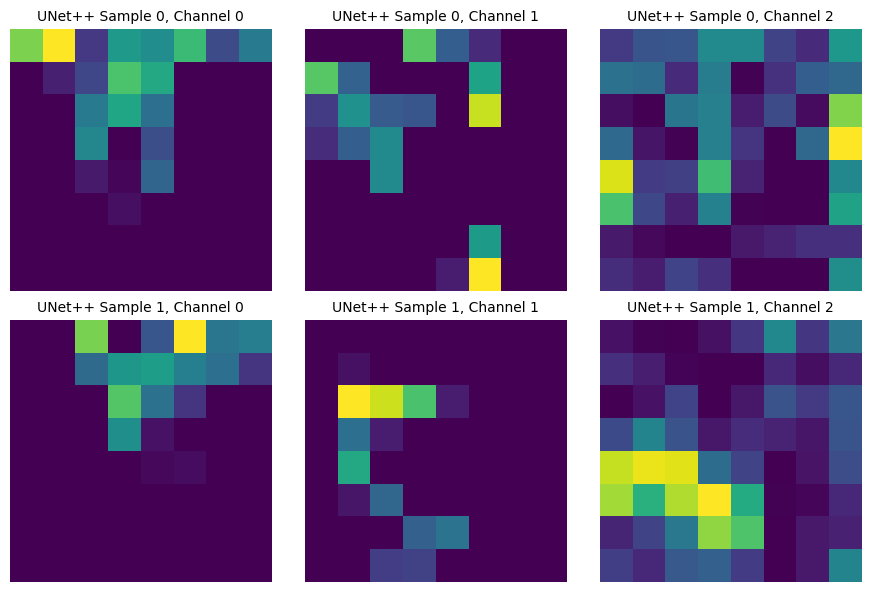

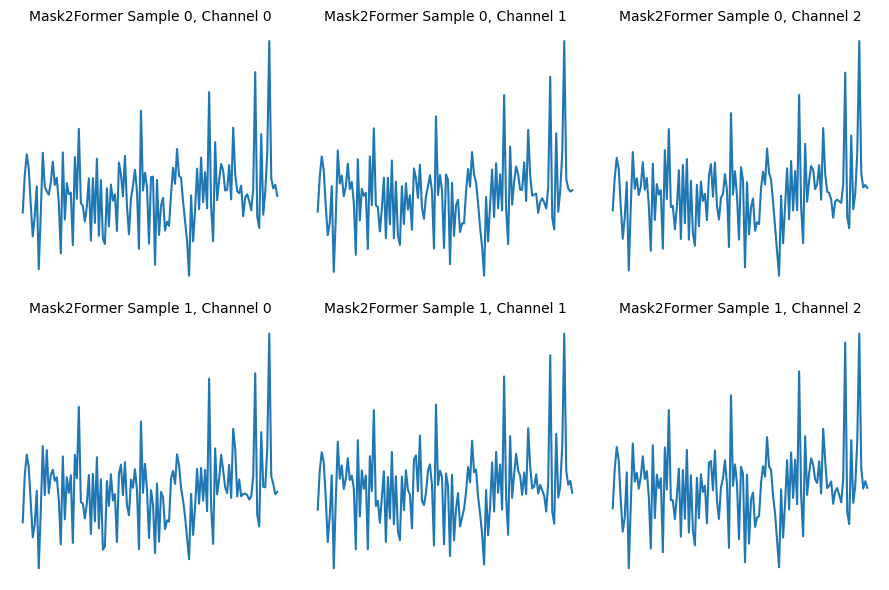

Visualizing UNet++ 'encoder.layer4' vs Mask2Former 'model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense'
Comparing layer 'encoder.layer4' (UNet++) vs. 'model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense' (Mask2Former).


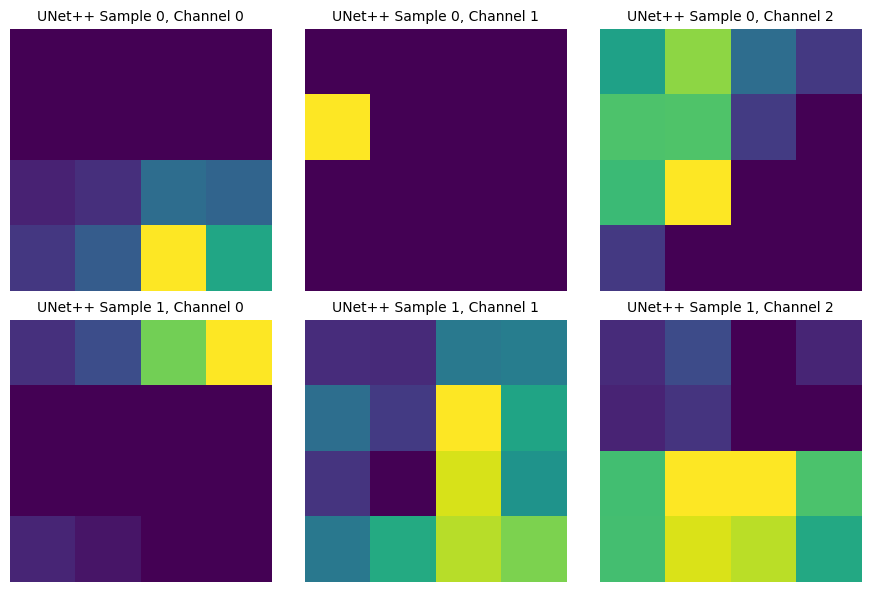

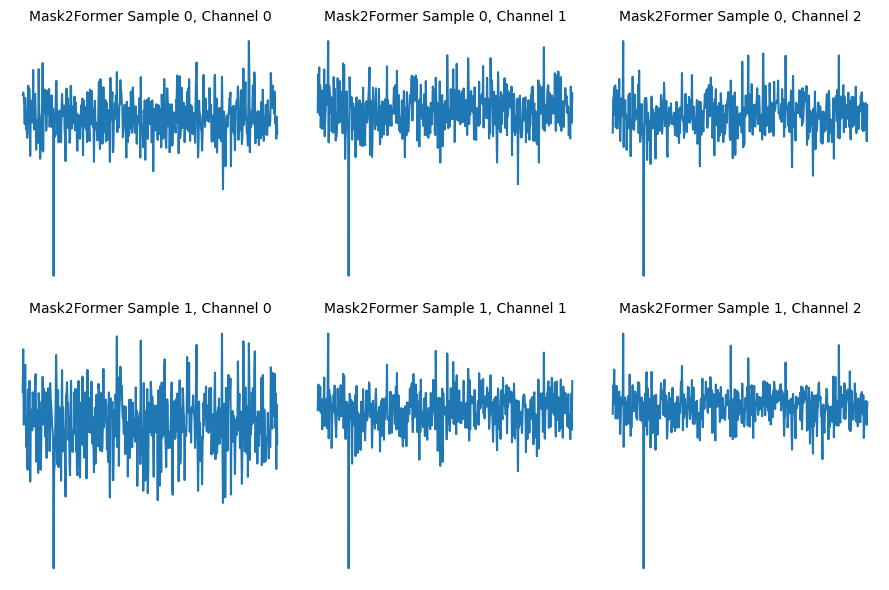

Visualizing UNet++ 'decoder.blocks.x_1_1.conv1' vs Mask2Former 'model.transformer_module.decoder.mask_predictor.mask_embedder.0.0'
Comparing layer 'decoder.blocks.x_1_1.conv1' (UNet++) vs. 'model.transformer_module.decoder.mask_predictor.mask_embedder.0.0' (Mask2Former).


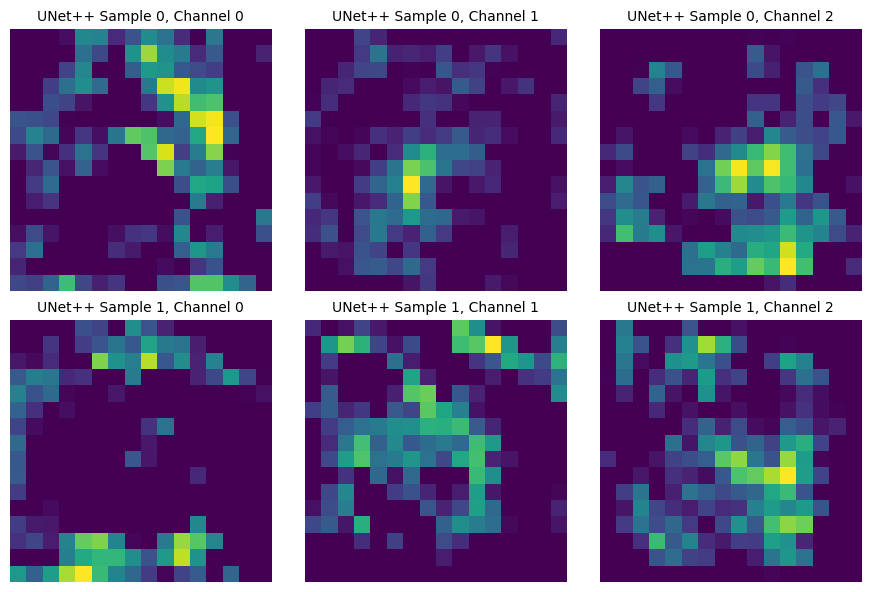

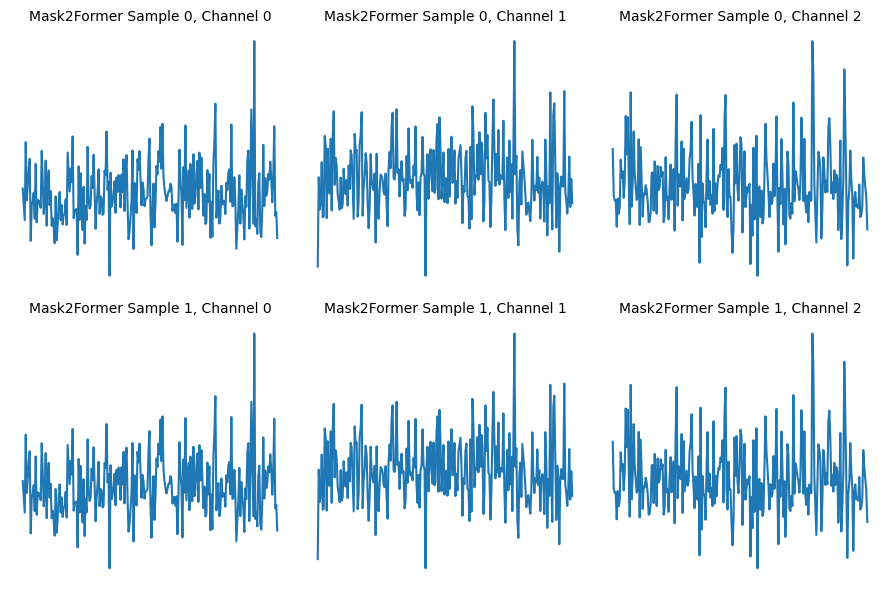

In [24]:


# visualize the encoder pair with the highest Linear CKA:
print("Visualizing UNet++ 'encoder.layer3' vs Mask2Former 'model.pixel_level_module.encoder.embeddings.norm' (highest Linear CKA)")
compare_activation_maps(features_unet, features_mask2former,
                        layer_unet="encoder.layer3",
                        layer_mask2former="model.pixel_level_module.encoder.embeddings.norm",
                        sample_indices=[0, 1],  # visualize 2 samples
                        channels_to_show=[0, 1, 2])

# visualize the encoder pair for higher-level features:
print("Visualizing UNet++ 'encoder.layer4' vs Mask2Former 'model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense'")
compare_activation_maps(features_unet, features_mask2former,
                        layer_unet="encoder.layer4",
                        layer_mask2former="model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense",
                        sample_indices=[0, 1],
                        channels_to_show=[0, 1, 2])

# visualize the decoder layers with the higher non-linear CKA:
print("Visualizing UNet++ 'decoder.blocks.x_1_1.conv1' vs Mask2Former 'model.transformer_module.decoder.mask_predictor.mask_embedder.0.0'")
compare_activation_maps(features_unet, features_mask2former,
                        layer_unet="decoder.blocks.x_1_1.conv1",
                        layer_mask2former="model.transformer_module.decoder.mask_predictor.mask_embedder.0.0",
                        sample_indices=[0, 1],
                        channels_to_show=[0, 1, 2])



### Preliminary Results

Our visualizations reveal that the activation maps from the compared layers are not directly comparable (to be expected as stated above):


These observations confirm that the raw activations, as obtained from the two architectures, are challenging to compare visually. This lack of direct comparability motivates the next steps, where we will apply additional techniques (such as further PCA, nonlinear alignment methods, and advanced correlation analyses) to transform and align the representations. The goal is to establish a common ground for more meaningful comparisons across these fundamentally different model architectures.

---

<br>
<br>
<br>

### PCA Visualization for All Mask2Former Candidate Layers


In this section,  we perform PCA on the activations from each candidate layer (both encoder and decoder candidates) to reduce the high-dimensional features into 3 principal components. This allows us to create “RGB” images from the activations for qualitative comparison. 



#### Function: `pca_to_3_channels()`

This function applies PCA to reduce the feature dimension of activation tensors to 3 channels, allowing you to visualize high-dimensional activations as “RGB” images. It supports two cases based on the input tensor shape:

- **CNN-like activations ([N, C, H, W])**:  
  The function flattens the spatial dimensions, applies PCA to reduce the number of channels to 3, reshapes the result back to [N, H, W, 3], and then transposes it to [N, 3, H, W].

- **Transformer-like activations ([N, hidden_dim, seq_len])**:  
  The function requires an additional parameter `shape_2d` (a tuple of (height, width)) that defines how to interpret `seq_len` as a 2D grid (height × width). It flattens the sequence dimension, applies PCA to reduce the dimension to 3, reshapes the output back to [N, seq_len, 3], and then reshapes this into [N, height, width, 3] before transposing to [N, 3, height, width].

In [26]:

from sklearn.decomposition import PCA

def pca_to_3_channels(acts, shape_2d=None, device="cpu"):
    """
    Apply PCA to reduce the feature dimension to 3 channels.

    acts: torch.Tensor or np.ndarray
          shape can be:
            - [N, C, H, W] (CNN)
            - [N, hidden_dim, seq_len] (Transformer)
          We'll flatten the feature dimension and reduce it to 3 via PCA.

    shape_2d: tuple (height, width), optional
              If acts is Transformer-based (N, hidden_dim, seq_len), we need
              to interpret seq_len as (height * width). For example, (8,16) for 128 tokens.

    returns: A np.ndarray with shape [N, 3, height, width]
             after PCA, we interpret the new dimension as 3 "channels."
    """

    # convert to CPU numpy
    if isinstance(acts, torch.Tensor):
        acts = acts.to(device).detach().cpu().numpy()

    if acts.ndim == 4:
        # case 1: CNN-like shape [N, C, H, W]
        N, C, H, W = acts.shape

        # flatten to [N * H * W, C]
        acts_flat = np.transpose(acts, (0, 2, 3, 1))  # [N, H, W, C]
        acts_flat = acts_flat.reshape(-1, C)         # [N*H*W, C]

        # PCA
        pca = PCA(n_components=3)
        acts_pca = pca.fit_transform(acts_flat)      # [N*H*W, 3]

        # reshape back to [N, H, W, 3]
        acts_pca = acts_pca.reshape(N, H, W, 3)
        # transpose to [N, 3, H, W]
        acts_pca = np.transpose(acts_pca, (0, 3, 1, 2))
        return acts_pca

    elif acts.ndim == 3:
        # case 2: Transformer-like shape [N, hidden_dim, seq_len]
        N, H_DIM, SEQ_LEN = acts.shape
        if shape_2d is None:
            raise ValueError("For a Transformer shape, you must provide shape_2d=(height, width) so we can reshape seq_len.")

        # flatten to [N * seq_len, hidden_dim]
        acts_flat = np.transpose(acts, (0, 2, 1))   # [N, seq_len, hidden_dim]
        acts_flat = acts_flat.reshape(-1, H_DIM)    # [N*seq_len, hidden_dim]

        # PCA
        pca = PCA(n_components=3)
        acts_pca = pca.fit_transform(acts_flat)     # [N*seq_len, 3]

        # reshape back: [N, seq_len, 3]
        N_new = acts_pca.shape[0] // SEQ_LEN
        acts_pca = acts_pca.reshape(N_new, SEQ_LEN, 3)

        # interpret seq_len as shape_2d
        h_patch, w_patch = shape_2d
        if h_patch * w_patch != SEQ_LEN:
            raise ValueError(f"seq_len={SEQ_LEN} does not match h_patch*w_patch={h_patch*w_patch}")

        # [N, h_patch, w_patch, 3]
        acts_pca = acts_pca.reshape(N_new, h_patch, w_patch, 3)
        # transpose to [N, 3, h_patch, w_patch]
        acts_pca = np.transpose(acts_pca, (0, 3, 1, 2))
        return acts_pca

    else:
        raise ValueError(f"Unsupported shape {acts.shape}; must be 4D (CNN) or 3D (Transformer).")

### PCA Visualization of Encoder Activations

we apply PCA to the encoder activation maps to reduce them to 3 channels for visualization. We use UNet++'s `encoder.layer3` (which has shape [N, C, H, W]) and the corresponding Transformer activation from `model.pixel_level_module.encoder.embeddings.norm` (which has shape [N, hidden_dim, seq_len]). For the Transformer activations, we reshape the sequence into a 2D grid (e.g., using an 8×16 grid) so that we can display them as images. This visualization allows us to compare the dominant variance in encoder features between the two models and assess whether they share similar spatial patterns.

### PCA Visualization of Decoder Activations

we focus on the decoder activation maps. We use UNet++'s `decoder.blocks.x_1_1.conv1` (with shape [N, C, H, W]) and compare it to the corresponding Transformer activation from `model.transformer_module.decoder.mask_predictor.mask_embedder.0.0` (with shape [N, hidden_dim, seq_len]). For the Transformer activations, we reshape the sequence into a 2D grid (for example, using a 16×16 grid) so that the activations can be visualized as images. This PCA-based visualization helps us examine the fine-tuned decoder features to determine if any shared nonlinear structure emerges between the two architectures.


In [27]:


# unet++ encoder activations, shape [N, C, H, W]
cnn_acts_encoder = features_unet["encoder.layer3"]  # e.g. [16, 64, 8, 8]
cnn_acts_pca_encoder = pca_to_3_channels(cnn_acts_encoder)  # shape [N, 3, 8, 8]

# transformer activations, shape [N, hidden_dim, seq_len]
transformer_acts_encoder = features_mask2former["model.pixel_level_module.encoder.embeddings.norm"]
transformer_acts_pca_encoder = pca_to_3_channels(transformer_acts_encoder, shape_2d=(8,16))  # need to inspect the shape of the transformer activations otherwise error



# unet++ decoder activations, shape [N, C, H, W]
cnn_acts_decoder = features_unet["decoder.blocks.x_1_1.conv1"]  # e.g. [16, 64, 8, 8]
cnn_acts_pca_decoder = pca_to_3_channels(cnn_acts_decoder)  # shape [N, 3, 8, 8]

# transformer decoder activations, shape [N, hidden_dim, seq_len]
transformer_acts_decoder = features_mask2former["model.transformer_module.decoder.mask_predictor.mask_embedder.0.0"]
transformer_acts_pca_decoder = pca_to_3_channels(transformer_acts_decoder, shape_2d=(16,16))  #  need to inspect the shape of the transformer activations otherwise error

### Function: `compare_3ch_maps()`

This function compares two 3-channel activation maps side by side. It is designed to work with activation maps that have been reduced to three channels via PCA. The function takes two inputs:
- `acts_cnn_3ch`: a tensor of shape `[N, 3, H, W]` representing the 3-channel activations from the CNN 
- `acts_trans_3ch`: a tensor of shape `[N, 3, H', W']` representing the 3-channel activations from the Transformer 

The function normalizes each activation map, transposes them into a format expected by matplotlib (`[H, W, 3]`), and then displays them side by side for visual comparison.


In [28]:


def compare_3ch_maps(acts_cnn_3ch, acts_trans_3ch, sample_idx=0):
    """
    Compare two 3-channel activation maps side by side.
    acts_cnn_3ch: [N, 3, H, W]
    acts_trans_3ch: [N, 3, H', W']
    """
    cnn_img = acts_cnn_3ch[sample_idx]  # shape [3, H, W]
    trans_img = acts_trans_3ch[sample_idx]  # shape [3, H', W']

    def normalize_3ch(x):
        x_min, x_max = x.min(), x.max()
        return (x - x_min) / (x_max - x_min + 1e-6)

    cnn_img_norm = normalize_3ch(cnn_img)
    trans_img_norm = normalize_3ch(trans_img)

    # Transpose to [H, W, 3] for plotting
    cnn_img_norm = np.transpose(cnn_img_norm, (1, 2, 0))
    trans_img_norm = np.transpose(trans_img_norm, (1, 2, 0))

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(cnn_img_norm)
    axs[0].set_title("CNN PCA (3 channels)")
    axs[0].axis("off")

    axs[1].imshow(trans_img_norm)
    axs[1].set_title("Transformer PCA (3 channels)")
    axs[1].axis("off")

    plt.show()


Comparing PCA maps for UNet++ and Mask2Former encoder activations:


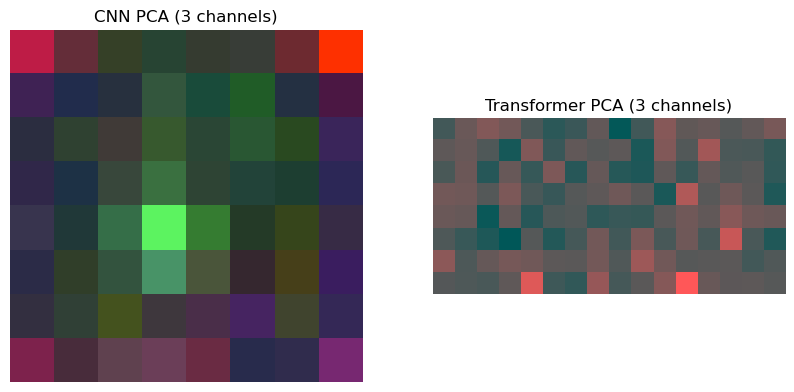

]

Comparing PCA maps for UNet++ and Mask2Former decoder activations:


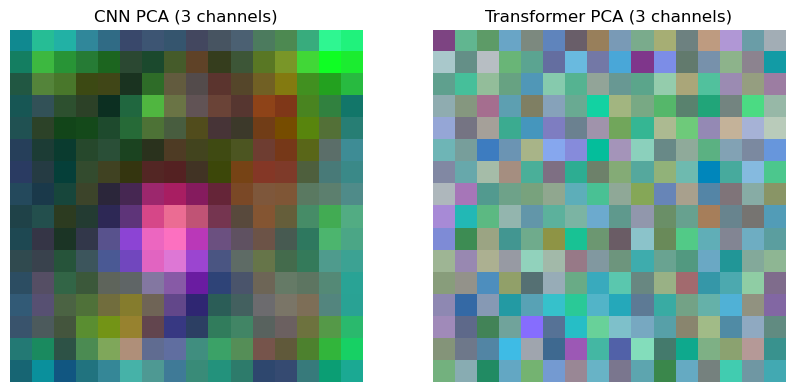

In [29]:

# call the function to compare the PCA maps
print("Comparing PCA maps for UNet++ and Mask2Former encoder activations:")
compare_3ch_maps(cnn_acts_pca_encoder, transformer_acts_pca_encoder, sample_idx=0)

print("]\n\nComparing PCA maps for UNet++ and Mask2Former decoder activations:")
compare_3ch_maps(cnn_acts_pca_decoder, transformer_acts_pca_decoder, sample_idx=0)

### Detailed Analysis: PCA-Reduced Visualizations of CNN vs. Transformer Activations

In this section, we examine the PCA-based “RGB” visualizations of activation maps from two key stages of our segmentation models: the encoder and the decoder. These images are derived from a dimensionality reduction of high-dimensional activations into 3 principal components, which are then interpreted as RGB channels.

#### Encoder Layer Analysis

- **Spatial Localization:**  
  The encoder visualization for UNet++ displays a pattern characterized by localized, well-defined color blocks. This is indicative of the inherent spatial locality of convolutional layers, where filters capture local features such as edges, textures, and other regional patterns.  
  In contrast, the Transformer (Mask2Former) encoder activation map exhibits a more dispersed and patchy color distribution. This suggests that the self-attention mechanism is blending information across wider spatial extents, resulting in features that are less localized but potentially more holistic.

- **Feature Distribution:**  
  The CNN encoder’s dominant color clusters imply that certain regions of the input are consistently activated, revealing a strong emphasis on specific local patterns. For the Transformer encoder, the color variability across patches points to a more global processing of the image, where attention mechanisms integrate information from multiple regions.

- **Interpretation of PCA Components:**  
  Since PCA captures the axes of greatest variance, the encoder visualizations suggest that the main sources of variation in Unet++ are tied to specific spatial features (such as textures or boundaries), while the Transformer’s variance is more evenly spread, reflecting its ability to capture contextual relationships across the image.

#### Decoder Layer Analysis

- **Increased Abstraction and Complexity:**  
  The decoder visualization for Unet++ shows color blocks that are more pronounced and structured compared to the encoder. This likely reflects the task-specific tuning that occurs during fine-tuning, where the decoder is optimized to produce accurate segmentation outputs. The clear, well-defined regions indicate that the decoder has learned to emphasize relevant segmentation cues.  
  On the other hand, the Transformer decoder activation map is characterized by lighter colors and a greater number of smaller, more numerous patches. This suggests that the Transformer’s decoder, while also fine-tuned for the segmentation task, maintains a more distributed representation of features. The presence of many smaller patches may be indicative of its multi-head attention mechanism, where different heads capture varied aspects of the input.

- **Nonlinear Relationships:**  
  Although our quantitative metrics (like Kernel CKA and RSA) hinted at some latent nonlinear alignment between the models, the decoder visualizations clearly underscore that the two architectures organize information in fundamentally different ways. The CNN decoder appears to form more contiguous, cohesive regions of activation, whereas the Transformer decoder disperses its representation over many small, diffuse areas.

- **Implications for Universality:**  
  The observed differences in both encoder and decoder visualizations confirm that, while there may be some underlying similarity in terms of overall performance on the segmentation task, the internal representations are shaped strongly by the model’s architectural design. The CNN’s inherent bias toward local processing and the transformer’s global, attention-based aggregation lead to distinctly different spatial patterns, even when both are optimized for the same task.

#### Overall Insights

- **Encoder Findings:**  
  The encoder activations reveal that pre-training produces some degree of alignment between the models, with the CNN exhibiting localized feature clusters and the transformer showing more dispersed patterns. This suggests that while both models capture meaningful features, the nature of these features is heavily influenced by their respective architectures.

- **Decoder Findings:**  
  The decoder activations, which are fine-tuned on the segmentation task, further accentuate the architectural differences. The CNN’s decoder produces more coherent and regionally defined maps, while the transformer’s decoder remains more fragmented and distributed. This difference reinforces the idea that fine-tuning alone does not fully align the internal representations of different model families.

These qualitative observations provide a valuable context for our quantitative metrics and motivate further exploration using advanced nonlinear alignment techniques to bridge the gap between these diverse architectures.

---

<br>
<br>

### Conclusion

This notebook presents an in-depth investigation into the internal representations of two state-of-the-art segmentation models—Unet++ (a CNN-based architecture) and Mask2Former (a Transformer-based architecture)—to evaluate the universality hypothesis. The central objective was to determine whether models trained on the same segmentation task converge to similar internal representations despite their fundamentally different design principles. Both quantitative metrics and qualitative visualizations were employed to provide a comprehensive view.

<br>

---

<br>


### Overview of Results


##### Encoder Comparisons

| UNet++ Layer         | Mask2Former Layer                                                           | Linear CKA | SVCCA    |
|----------------------|-----------------------------------------------------------------------------|------------|----------|
| `encoder.layer3`     | `model.pixel_level_module.encoder.embeddings.norm`                         | 0.3569     | -0.0475  |
| `encoder.layer4`     | `model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense`  | 0.2382     | -0.0353  |

These encoder results indicate moderate linear similarity—likely due to the shared pre-training but also reveal inconsistent subspace alignment as evidenced by slightly negative SVCCA values.

##### Decoder Comparisons

| UNet++ Layer            | Mask2Former Layer                                              | Linear CKA | SVCCA    | Kernel CKA | RSA (Spearman) |
|-------------------------|----------------------------------------------------------------|------------|----------|------------|----------------|
| `decoder.blocks.x_1_1.conv1`  | `model.transformer_module.decoder.mask_predictor.mask_embedder.0.0` | 0.0682     | 0.0196   | 0.0818     | 0.0094         |
| `decoder.blocks.x_1_1.conv1`  | `model.transformer_module.decoder.mask_predictor.mask_embedder.1.0` | 0.0246     | -0.0420  | 0.0768     | -0.0270        |
| `decoder.blocks.x_1_1.conv1`  | `model.transformer_module.decoder.mask_predictor.mask_embedder.2.0` | 0.0516     | 0.0209   | 0.0602     | 0.0121         |
| `segmentation_head.0`  | `model.transformer_module.decoder.mask_predictor.mask_embedder.0.0`     | 0.0367     | nan      | 0.0349     | nan            |
| `segmentation_head.0`  | `model.transformer_module.decoder.mask_predictor.mask_embedder.1.0`     | 0.0010     | nan      | 0.0254     | nan            |
| `segmentation_head.0`  | `model.transformer_module.decoder.mask_predictor.mask_embedder.2.0`     | 0.0204     | nan      | 0.0114     | nan            |

The decoder comparisons demonstrate that the fine-tuned representations exhibit very low alignment in both linear and nonlinear measures. Even when a modest Kernel CKA (up to 0.0818) is observed for the intermediate decoder layers, the overall similarity remains minimal. Comparisons involving UNet++’s final output (`segmentation_head.0`) are especially poor.

<br>

---

<br>

#### Quantitative Analysis

Several similarity metrics were computed across selected layers of the two models:

- **Linear Metrics:**  
  - **Linear CKA:** Encoder comparisons showed a Linear CKA of approximately 0.3569 for Unet++’s `encoder.layer3` versus Mask2Former’s `model.pixel_level_module.encoder.embeddings.norm`, indicating moderate linear alignment in mid-level features. For higher-level encoder features (`encoder.layer4` vs. `model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense`), Linear CKA was around 0.2382. In contrast, decoder layers exhibited very low Linear CKA values—for example, UNet++’s `decoder.blocks.x_1_1.conv1` versus Mask2Former’s `mask_embedder.0.0` showed a value of approximately 0.0295—suggesting minimal linear similarity in task-specific representations.

- **Nonlinear Metrics:**  
  - **Kernel CKA:** Although nonlinear metric values were modest (e.g., around 0.0818 for the UNet++ `decoder.blocks.x_1_1.conv1` vs. Mask2Former’s `mask_embedder.0.0` comparison), these values indicate some shared structure within a nonlinear manifold.  
  - **SVCCA and RSA:** SVCCA results were near zero or even slightly negative in many cases (and undefined for comparisons involving extremely low-dimensional outputs such as `segmentation_head.0`), while RSA produced similarly weak correlations. Overall, both measures suggest that even advanced subspace and relational comparisons do not reveal strong alignment between the internal representations of these architectures.

<br>

---

<br>

### Final Performance Results and Implications

**UNet++ on the Test Set:**  
- **Mean IoU:** 0.8265  
- **Mean Dice:** 0.8983  
- **Mean Pixel Accuracy:** 0.9394  

**Mask2Former on the Test Set:**  
- **Mean IoU:** 0.8034  
- **Mean Dice:** 0.8835  
- **Mean Pixel Accuracy:** 0.9297  

Training performance indicated that both models reached similar overall metrics during fine-tuning, with strong performance on the segmentation task. However, further evaluation—particularly of the decoder layers which were fine-tuned (as opposed to the frozen encoder layers) showed a different picture. The quantitative analysis of the decoders showed very low linear and only modest nonlinear similarities, indicating minimal convergence in internal representations between the architectures.

These updated results confirm that even though both architectures perform comparably on the task (as reflected in similar quantitative performance), the internal features, especially in the task-specific decoders, remain largely divergent. This divergence implies that the expected universality—that similar tasks lead to similar internal representations—is not supported across architectures with large SOTA segmentation models. Advanced projection and alignment techniques may be required to further investigate and potentially bridge the latent representational gap between CNN-based and Transformer-based models.

<br>

---

<br>

#### Qualitative Visualization and PCA Exploration

PCA was applied to high-dimensional activation maps to project them into a 3-channel “RGB” space for visualization:

- **Encoder Visualizations:**  
  The PCA-based images for encoder layers revealed that Unet++ produces localized, block-like activations, indicative of strong spatial locality in convolutional operations. In contrast, the Transformer encoder activations appear more globally mixed, reflecting the influence of the self-attention mechanism. Although quantitative metrics suggest moderate similarity, the visual differences underscore distinct spatial encoding strategies.
  
- **Decoder Visualizations:**  
  The PCA visualizations of decoder layers further illustrate divergence. Unet++’s decoder activations, such as those from `decoder.blocks.x_1_1.conv1`, exhibit coherent, regionally defined patterns. On the other hand, the corresponding transformer decoder activations show more numerous and fragmented patches with lighter colors, implying that task-specific fine-tuning does not fully align the representations between the models.

The exploration with PCA demonstrated that while dimensionality reduction helps visualize the dominant variance in the activations, it does not capture the full complexity of the nonlinear transformations unique to each architecture. This indicates a need for more sophisticated projection techniques to map the representations into a common latent space.

<br>

---

<br>

#### Future Directions: Projection and Alignment Techniques

Based on the modest nonlinear alignment observed, further work should explore advanced projection techniques to better align the latent spaces of CNNs and Transformers. Approaches such as:
- **Canonical Correlation Analysis (CCA)**
- **Procrustes Analysis**
- **Manifold Alignment Techniques**

could provide a more direct comparison between the features learned by each model and reveal deeper, underlying similarities that raw metrics and PCA-based visualizations fail to capture.

<br>

---

<br>

#### Final Thoughts

The comprehensive analysis clearly demonstrates the absence of universality across architectures for large segmentation models. Despite both Unet++ and Mask2Former achieving comparable performance on the segmentation task, the internal representations do not converge to a similar structure. In fact, while the encoder layers frozen during fine-tuning exhibit only modest alignment, the decoder layers, which were fine-tuned on the same exact task, show very weak similarity. This result was unexpected: it was anticipated that the decoders, being task-specific and trained under identical conditions, would converge more strongly. Instead, the low linear similarity and modest nonlinear alignment reveal that inherent inductive biases in CNNs versus Transformers lead to fundamentally different ways of encoding and processing information.

This notebook serves as a detailed case study in mechanistic interpretability and provides clear evidence that there is no cross-architecture universality for these large segmentation models. It also lays the groundwork for future research aimed at bridging this representational gap through advanced alignment and projection techniques.